# **Imbalanced Class Prediction: Credit Card Fraud**

## **Introduction:**

Traditional machine learning models often struggle with imbalanced datasets, where one class is vastly outnumbered by another. This imbalance can lead to models that perform poorly at detecting the minority class due to bias towards the majority class. This is especially problematic when a misclassification of the minority class has disproportionate consequences, such as in the case of detecting credit card fraud. 

To enhance a model's ability to identify the minority class accurately, this projects levarages `imbalanced-learn` resamplers, notably; RandomOverSampler, RandomUnderSampler, TomekLinks, SMOTE, SMOTETomek, and ADASYN. These were tested on three models: Logistic Regression (L1), Logistic Regression (L2), and RandomForestClassifier.

## **About the Data**:

The dataset used was the `Credit Card Fraud Detection` dataset which was retrieved from [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The anonymized dataset contains transactions made by credit cards in September 2013 by European cardholders, where 492 frauds were identified out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of dimensionality reduction using PCA.  Features V1, V2, … V28 are the principal components obtained from PCA reduction, while the features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.  The 'Class' column is the target feature with value 1 indicating fraud and 0 if otherwise.

For speed and GitHub limitations, the model was sampled to contain only 50,000 datapoints.

## **Methodology**
* **Data Loading**: Load data from csv
* **Data Cleaning**: Drop NaN values and duplicates
* **Data Preprocessing**: This step normally involves scaling of numerical features and dimensionality reduction; however, the uploaded dataset had already been reduced
* **Train Test Split**: Create train-test datasets
* **Hyperparameter Tuning**: Using `GridSearchCV`, obtain the best model for every model-resampler combination and record results
* **Evaluation**: Identify the top model-resampler combinations and evaluate using ROC-AUC and Average Precision

## **Summary of Results**

The best model was found to be Logistic Regression (C=1) with L1 regularization  when fitted on a resampled training dataset using TomekLinks. This was determined using the ROC-AUC and PR-AUC metrics. Accuracy was not used due to the highly imbalanced nature of the dataset. Precision, recall, and F1-scores were also not used as these depend on the threshold selected.

The best resampling method for each model is recorded below:

| name            | fit_time | test_roc | test_ap | test_accuracy |
|-----------------|----------|----------|---------|---------------|
| logistic_l1-Tomek | 0.452  | 0.995    | 0.829   | 0.999         |
| logistic_l2-Tomek | 0.270  | 0.995    | 0.823   | 0.999         |
| rf-SMOTETomek     | 32.180 | 0.987    | 0.832   | 0.999         |


# **Execution**

## **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, auc,
                             precision_recall_curve, average_precision_score,
                             roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

## **Data Loading**

The dataset used was the `Credit Card Fraud Detection` dataset which was originally retrieved from [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) and reduced to a random 50,000 rows.

The data contains only numerical input variables which are the result of dimensionality reduction using PCA.  Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Class' column is the target feature with value 1 indicating fraud and 0 if otherwise.

---

Machine Learning Group - ULB, "Credit Card Fraud Detection Dataset." Kaggle. Available at: [https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Accessed on June 15, 2024.


In [2]:
# Load 
df = pd.read_csv('creditcard.csv')

display(df.head(3).round(3))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,143912.0,-1.229,1.722,-1.216,-0.622,0.129,-0.702,0.137,0.782,-0.149,...,0.454,1.321,0.031,0.790,-0.672,-0.274,0.331,0.307,0.74,0
1,129625.0,0.619,-2.345,-0.607,1.682,-1.126,0.778,-0.029,0.118,0.740,...,0.539,0.213,-0.285,0.718,-0.578,-0.854,-0.043,0.093,660.00,0
2,57186.0,-1.049,1.013,1.047,0.927,0.398,0.144,0.092,0.536,-1.207,...,0.197,0.426,-0.234,-0.271,0.544,-0.123,-0.225,-0.100,2.35,0


In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
# Data  Cleaning 
df = df.drop_duplicates()
df = df.dropna()
df.reset_index(drop=True, inplace=True)

## **Preprocessing**

In [5]:
# Split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    stratify=y,
                                                    random_state=42)

In [6]:
# Scale non-PCA components features
scaler = StandardScaler()
X_train[['Time','Amount']] = scaler.fit_transform(X_train[['Time','Amount']])
X_test[['Time','Amount']] = scaler.transform(X_test[['Time','Amount']])

## **Exploratory Data Analysis**

Not fraud:  49861
Fraud:      84


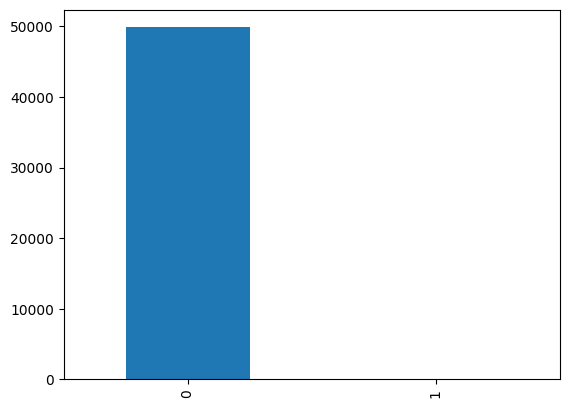

In [7]:
print(f"Not fraud:  {df.Class.value_counts()[0]}")
print(f"Fraud:      {df.Class.value_counts()[1]}")
df['Class'].value_counts().plot.bar();

There is weak correlation between the features as the data has already been preprocessed using dimensionality reduction, namely Principal Component Analysus (PCA). PCA achieves this by transforming the original data into a set of linearly uncorrelated variables known as principal components. These components are ordered so that the first few retain most of the variation present in all of the original variables. As a result, the redundancy and correlation within the data are minimized, which is evident in the weak correlations between the transformed features. This can be beneficial for many machine learning algorithms that perform better on datasets where the features are not closely related, reducing issues like multicollinearity.

The features in the original dataset are components.

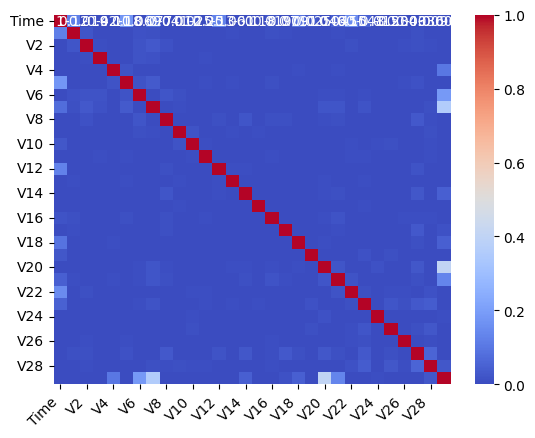

In [8]:
sns.heatmap(X.corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.xticks(rotation=45, ha='right')
ax = plt.gca()

plt.show()

**Proportional Chance Criterion (PCC)**

Due to the highly imbalanced nature of the data, the PCC metric is nonsensical and not useful in this case. Given that the goal is in identifying fraudulent transactions, precision or recall scores would be more helpful as these metrics exclude true-negatives from the scoring calculation.

In [9]:
PCC = sum((y.value_counts() / len(y))**2)
print("Proportion Chance Criterion = {}%".format(100*PCC))
print("1.25*Proportion Chance Criterion = {}%".format(1.25*100*PCC))

Proportion Chance Criterion = 99.66419571690037%
1.25*Proportion Chance Criterion = 124.58024464612546%


## **Model x Resampler Testing**

### **Set-Up**

In [10]:
seed = 42
np.random.seed(seed)

# Create a NoResampling class that performs no rebalancing
class NoResampling:
    def fit_resample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def set_params(self, **params):
        return self

# Dictionary of all Resampling methods to be tested
resampling_methods = {
    'Original': NoResampling(),
    'ROS': RandomOverSampler(),
    'RUS': RandomUnderSampler(),
    'Tomek': TomekLinks(),
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN(),
    'SMOTETomek': SMOTETomek()
}

# Dictionary of models to be tested
models = {
    'logistic_l1': LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      max_iter=3000, 
                                      random_state=seed),
    'logistic_l2': LogisticRegression(penalty='l2',
                                      dual=False,
                                      max_iter=3000, random_state=seed),
    'rf': RandomForestClassifier(random_state=seed),
}

# Grid for hyperparameter tuning
param_grid = {
    'logistic_l1': {
        'C': [0.01, 0.1, 1]
    },
    'logistic_l2': {
        'C': [0.01, 0.1, 1]
    },
    'rf': {
        'n_estimators': [100],
        'max_depth': [10],
    }
}

### **Gridsearch**

**Explanation:**

1. **Initialization**: Prepare lists and dictionaries to store results and best models. Set up a `StratifiedKFold` cross-validation strategy with 3 splits.

2. **Outer Loop - Resampling Methods**:
    - Iterate over each resampling method provided in the `resampling_methods` dictionary.
    - Apply the resampling method to the training data to balance the classes, generating `X_resampled` and `y_resampled`.

3. **Inner Loop - Model Training**:
    - Iterate over each machine learning model specified in the `models` dictionary.
    - Combine the model name with the resampling method to create a unique identifier for the configuration.

4. **Model Tuning**:
    - Setup `GridSearchCV` for each model configuration using its respective parameter grid, specifying F1-score as the performance metric, and enabling parallel processing.
    - Fit `GridSearchCV` on the resampled training data and determine the best model configuration.

5. **Performance Metrics Calculation**:
    - Extract and store the fitting time, training F1-score, and validation F1-score.
    - Predict on the test set and calculate various metrics like F1-score, ROC AUC, Average Precision, and Accuracy.

6. **Results Collection**:
    - Compile all relevant metrics into a dictionary for each model configuration and append it to the results list.

7. **Progress Tracking**:
    - Update the progress after each iteration to monitor the completion percentage.

This structured approach ensures that each combination of resampling method and model is systematically evaluated, optimizing for the best performance on the validation set while also considering the generalization on the test set.

In [11]:
# Initialize to store results
results = []
best_models_dict = {}
cv = StratifiedKFold(n_splits=3)

# Progress Updater
i = 0
tasks = len(resampling_methods) * len(models)

# Execute
for resample_method, resampler in resampling_methods.items():
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

    for model_name, model in models.items():
        # Name
        combo_name = f'{model_name}-{resample_method}'

        # GridSearchCV
        grid_search = GridSearchCV(model, 
                                   param_grid[model_name],
                                   cv=cv,
                                   n_jobs=-1,
                                   scoring='f1', 
                                   return_train_score=True)
        grid_search.fit(X_resampled, y_resampled)
        best_model = grid_search.best_estimator_

        # Get Train Val Metrics
        idx = grid_search.best_index_
        fit_time = grid_search.cv_results_['mean_fit_time'][idx]
        train_f1 = grid_search.cv_results_['mean_train_score'][idx]
        val_f1 = grid_search.cv_results_['mean_test_score'][idx]

        # Get Test Metrics
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        test_ap = average_precision_score(y_test, y_pred_proba)
        fpr, tpr, thr = roc_curve(y_test, y_pred_proba)
        test_roc = auc(fpr, tpr)
        test_f1 = f1_score(y_test, y_pred)
        test_auprc = average_precision_score(y_test, y_pred_proba)
        test_accuracy = accuracy_score(y_test, y_pred)

        # Collect result
        result = {'name': combo_name,
                  'fit_time': fit_time,
                  'train_f1': train_f1,
                  'val_f1': val_f1,
                  'test_f1': test_f1,
                  'test_roc': test_roc,
                  'test_ap': test_ap,
                  'test_accuracy': test_accuracy}

        results.append(result)

        # Print progress
        i += 1
        print(f"Iteration {(i/tasks)*100:.1f}%, last: {combo_name}", end='\r') 

# **Evaluation**

## **Results**

In [12]:
df_results = pd.DataFrame(results) \
    .sort_values(by=['test_roc', 'test_ap'], ascending=False)
df_results.round(3).head(10)

,name,fit_time,train_f1,val_f1,test_f1,test_roc,test_ap,test_accuracy
11,rf-Tomek,13.796,0.969,0.797,0.839,1.000,0.951,0.999
5,rf-ROS,12.077,1.000,1.000,0.839,1.000,0.957,0.999
2,rf-Original,13.574,0.973,0.817,0.839,1.000,0.944,0.999
8,rf-RUS,0.132,1.000,0.938,0.104,1.000,0.883,0.971
14,rf-SMOTE,32.565,1.000,1.000,0.683,1.000,0.885,0.999
20,rf-SMOTETomek,32.622,1.000,1.000,0.684,0.999,0.873,0.999
7,logistic_l2-RUS,0.006,0.961,0.944,0.121,0.999,0.840,0.975
17,rf-ADASYN,30.209,1.000,0.958,0.565,0.999,0.793,0.998
6,logistic_l1-RUS,0.004,0.977,0.930,0.066,0.998,0.755,0.952
3,logistic_l1-ROS,3.551,0.974,0.974,0.124,0.942,0.875,0.977


## **Top Results**

In [13]:
def top_by_model(df, substrings):
    summarized_df = pd.DataFrame()
    for substring in substrings:
        temp_df = df[df['name'].str.contains(substring)]
        if not temp_df.empty:
            summarized_df = pd.concat([summarized_df, temp_df.head(1)], ignore_index=True)
    return summarized_df

model_types = ['logistic_l1', 'logistic_l2', 'rf']
df_results_summarized = top_by_model(df_results, model_types)
df_results_summarized.round(3)[['name', 'fit_time', 'test_roc', 
                                'test_ap', 'test_accuracy']]

,name,fit_time,test_roc,test_ap,test_accuracy
0,logistic_l1-RUS,0.004,0.998,0.755,0.952
1,logistic_l2-RUS,0.006,0.999,0.840,0.975
2,rf-Tomek,13.796,1.000,0.951,0.999


## **Best Model: AUC Curves**

In [14]:
model = LogisticRegression(penalty='l1',
                           solver='liblinear',
                           max_iter=3000, 
                           random_state=seed)

X_resampled, y_resampled = TomekLinks().fit_resample(X_train, y_train)

# Grid for hyperparameter tuning
param_grid = {
        'C': [0.01, 0.1, 1]
    }

# GridSearchCV
grid_search = GridSearchCV(model, 
                        param_grid,
                        cv=cv,
                        n_jobs=-1,
                        scoring='f1', 
                        return_train_score=True)
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

# Get Test Metrics
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Get AUCs
fpr, tpr, thr = roc_curve(y_test, y_pred_proba)
test_roc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

In [15]:
print('Params: \n--')
for param, value in best_model.get_params().items():
    print(f"{param}: {value}")

Params: 
--
C: 1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 3000
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


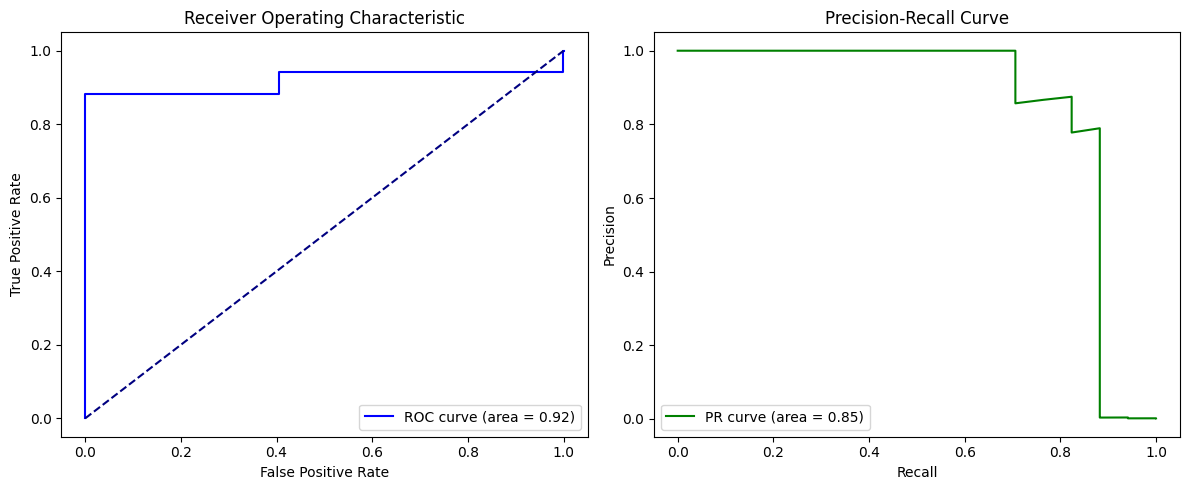

In [16]:
# Plotting
plt.figure(figsize=(12, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {test_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Subplot 2: Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Show plots
plt.tight_layout()
plt.show()


# **Acknowledgements**

Guillaume Lemaitre, Fernando Nogueira, and Christos K. Aridas. "Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning." *Journal of Machine Learning Research* 18, no. 17 (2017): 1-5.

I. Tomek. “Two modifications of CNN.” *IEEE Transactions on Systems, Man, and Cybernetics* (1976): 769-772.

N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer, "SMOTE: Synthetic Minority Over-sampling Technique." *Journal of Artificial Intelligence Research* 16 (2002): 321-357.

H. He, Y. Bai, E. A. Garcia, and S. Li. "ADASYN: Adaptive synthetic sampling approach for imbalanced learning." In *IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence)*, pages 1322-1328, June 2008.

---<br>

Machine Learning Group - ULB, "Credit Card Fraud Detection Dataset." Kaggle. Available at: [https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Accessed on June 15, 2024.
